# Load Packages

In [1]:
from collections import defaultdict
from itertools import permutations, combinations
from time import time

import gurobipy as gp
import matplotlib.pyplot as plt
import pandas as pd

### Calculate Distance

In [51]:
# Calculates distance using Manhattan
def calculate_distance_manhattan(lat1, lon1, lat2, lon2):
    # Calculate the absolute differences
    dlat = abs(lat2 - lat1)
    dlon = abs(lon2 - lon1)
    
    # Sum up the absolute differences
    return dlat + dlon

In [52]:
# Create the distance matrix between every two locations
def create_distance_matrix(locations):
    distance_matrix = {}
    for ind1, loc1 in locations.iterrows():
        for ind2, loc2 in locations.iterrows():
            dist = calculate_distance_manhattan(loc1['Lat'], loc1['Long'], loc2['Lat'], loc2['Long'])
            distance_matrix[(ind1, ind2)] = dist
    return distance_matrix

### Savings

In [ ]:
def calculate_savings(distance_matrix, num_nodes):
    """Calculate and sort the savings between each pair of customers."""
    savings = {}
    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            saving = distance_matrix[(1, i)] + distance_matrix[(1, j)] - distance_matrix[(i, j)]
            savings[(i, j)] = saving
    return {k: v for k, v in sorted(savings.items(), key=lambda item: item[1], reverse=True)}

### Create Routes

In [ ]:
# Calculate the cost of each route
def calculate_cost(route_distance):
    return max(route_distance * 1.5, 450)

In [55]:
input_data = pd.read_csv("manhattan_customers20.csv", index_col=0)
max_stops = 4
num_nodes = input_data.shape[0]

dist_matrix = create_distance_matrix(input_data)

({(2,): 0.0251000000000019,
  (3,): 0.09189999999999543,
  (4,): 0.09330000000000638,
  (5,): 0.09629999999999939,
  (6,): 0.09199999999999875,
  (7,): 0.06320000000000903,
  (8,): 0.08440000000000225,
  (9,): 0.08780000000000143,
  (10,): 0.08420000000000272,
  (11,): 0.09130000000000393,
  (12,): 0.07869999999999777,
  (13,): 0.023400000000002308,
  (14,): 0.045900000000010266,
  (15,): 0.04639999999999844,
  (16,): 0.05170000000001096,
  (17,): 0.046999999999997044,
  (18,): 0.03930000000000433,
  (19,): 0.008600000000008379,
  (20,): 0.09730000000000416,
  (21,): 0.07559999999999434,
  (2, 3): 0.10829999999999984,
  (2, 4): 0.10970000000001079,
  (2, 5): 0.1127000000000038,
  (2, 6): 0.10840000000000316,
  (2, 7): 0.07960000000001344,
  (2, 8): 0.10080000000000666,
  (2, 9): 0.10420000000000584,
  (2, 10): 0.10060000000000713,
  (2, 11): 0.10770000000000834,
  (2, 12): 0.09510000000000218,
  (2, 13): 0.03980000000000672,
  (2, 14): 0.06230000000001468,
  (2, 15): 0.0628000000000028

In [35]:
def calculate_distance_matrix(locations):
    """Calculate the distance matrix using Manhattan distance."""
    dist_matrix = {}
    for i, coord1 in locations.items():
        for j, coord2 in locations.items():
            dist_matrix[(i, j)] = calculate_distance_manhattan(coord1[0], coord1[1], coord2[0], coord2[1])
    return dist_matrix

def clarke_wright_heuristic(dist_matrix, num_nodes, max_stops):
    """Create routes using Clarke-Wright Savings Algorithm."""
    sorted_savings = calculate_savings(dist_matrix, num_nodes)
    routes = []
    added = set()

    for (i, j), _ in sorted_savings.items():
        if i in added and j in added:
            continue

        # Try to add to an existing route
        added_to_route = False
        for route in routes:
            if len(route) >= max_stops - 1:  # Subtracting 1 as depot is not included
                continue

            if route[0] == i and route[-1] != j:
                route.insert(0, j)
                added.add(j)
                added_to_route = True
                break
            elif route[-1] == i and route[0] != j:
                route.append(j)
                added.add(j)
                added_to_route = True
                break
            elif route[0] == j and route[-1] != i:
                route.insert(0, i)
                added.add(i)
                added_to_route = True
                break
            elif route[-1] == j and route[0] != i:
                route.append(i)
                added.add(i)
                added_to_route = True
                break

        # Create a new route if (i, j) cannot be added to existing routes
        if not added_to_route:
            routes.append([i, j])
            added.add(i)
            added.add(j)

    # Connect uncaptured customers directly to the depot
    for i in range(1, num_nodes + 1):
        if i not in added:
            routes.append([i])

    return routes


# Calculate the distance of a single route
def calculate_route_distance(route, dist_matrix):
    distance = 0
    distance += dist_matrix[(1, route[0])]
    for i in range(len(route) - 1):
        distance += dist_matrix[(route[i], route[i+1])]
    distance += dist_matrix[(route[-1], 1)]
    return distance

# Calculate the total cost of the routes using a custom cost function
def calculate_total_cost_with_custom_function(routes, dist_matrix):
    total_cost = 0
    for route in routes:
        route_distance = calculate_route_distance(route, dist_matrix)
        route_cost = calculate_cost(route_distance)
        total_cost += route_cost
    return total_cost

# Calculate the naive cost of visiting each customer directly from the depot
def calculate_naive_cost(num_nodes, dist_matrix):
    naive_cost = 0
    for i in range(1, num_nodes + 1):
        distance_to_and_fro = 2 * dist_matrix[(1, i)]  # To and from the depot
        naive_cost += calculate_cost(distance_to_and_fro)  # Use the custom cost function
    return naive_cost

# Calculate the cost of each route
def calculate_cost(route_distance):
    return max(route_distance * 1.5, 450)

# Calculate Lower Bound based on Distance
def calculate_lower_bound_distance(dist_matrix, num_nodes):
    return 2 * sum(dist_matrix[(1, i)] for i in range(1, num_nodes + 1))

# Calculate Lower Bound based on Savings
def calculate_lower_bound_savings(dist_matrix, num_nodes):
    naive_cost = calculate_naive_cost(num_nodes, dist_matrix)
    total_savings = sum(calculate_savings(dist_matrix, num_nodes).values())
    return naive_cost - total_savings

# Execution
max_stops = 4
num_nodes = input_data.shape[0]

# Assuming routes and dist_matrix are already calculated
total_cost_optimized = calculate_total_cost_with_custom_function(routes, dist_matrix)
naive_cost = calculate_naive_cost(num_nodes, dist_matrix)

# Calculate lower bounds
lower_bound_distance = calculate_lower_bound_distance(dist_matrix, num_nodes)
lower_bound_savings = calculate_lower_bound_savings(dist_matrix, num_nodes)

print(f"Total cost after optimization: {total_cost_optimized}")
print(f"Naive total cost: {naive_cost}")
print(f"Lower Bound (Distance): {lower_bound_distance}")
print(f"Lower Bound (Savings): {lower_bound_savings}")


Total cost after optimization: 4950
Naive total cost: 9450
Lower Bound (Distance): 2.6468000000000984
Lower Bound (Savings): 9431.622


In [25]:
import numpy as np

def plot_routes(routes, locations):
    """Plot the routes on a scatter plot."""
    
    # Scatter plot for locations
    plt.scatter(locations['Long'], locations['Lat'], c='blue', label='Customer')
    plt.scatter(locations.loc[1, 'Long'], locations.loc[1, 'Lat'], c='red', label='Depot')
    
    # Annotate each point with its customer ID
    for ind, row in locations.iterrows():
        plt.annotate(ind, (row['Long'], row['Lat']), textcoords="offset points", xytext=(0,5), ha='center')
        
    # Plot lines for routes
    for route in routes:
        route_coords = locations.loc[route, ['Long', 'Lat']].values
        route_coords = np.vstack([locations.loc[1, ['Long', 'Lat']], route_coords, locations.loc[1, ['Long', 'Lat']]])  # Adding depot at start and end
        plt.plot(route_coords[:, 0], route_coords[:, 1])

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.title('Customer Routes')
    plt.show()

# After defining this function, use the following line to plot your routes
# plot_routes(routes, input_data)


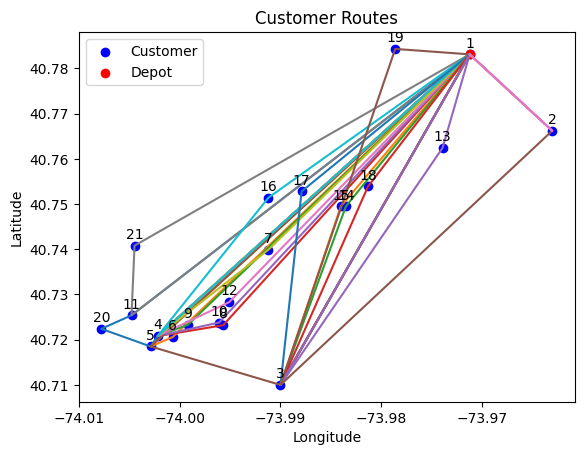

In [26]:
plot_routes(routes, input_data)